# Part 1: Data Preprocessing and Exploration

## 1.1 Data Loading and Exploration

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

### Load the dataset

In [2]:
data = pd.read_csv("financial-news-tweets-corpus.csv")

### Display the head of the dataset to understand its structure

In [3]:
display(data.head())

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,Bearish
1,$CCL $RCL - Nomura points to bookings weakness...,Bearish
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",Bearish
3,$ESS: BTIG Research cuts to Neutral https://t....,Bearish
4,$FNKO - Funko slides after Piper Jaffray PT cu...,Bearish


### Ensure there is no missing value

In [4]:
display(data.isnull().sum())

text     0
label    0
dtype: int64

### Clean mislabeling issues

In [5]:
data = data[data['label'].isin(['Bearish', 'Bullish', 'Neutral'])]

### Remove potential diplicate rows

In [6]:
data = data.drop_duplicates()

### Check label distribution

In [7]:
display(data['label'].value_counts())

label
Neutral    7743
Bullish    2398
Bearish    1789
Name: count, dtype: int64

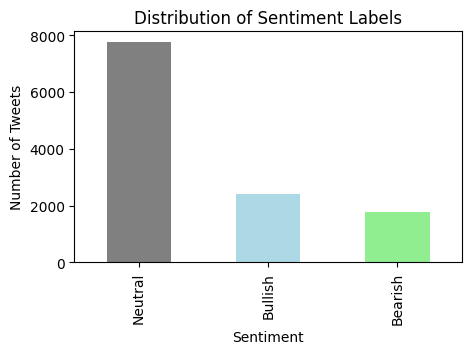

In [8]:
plt.figure(figsize=(5, 3))
data['label'].value_counts().plot(kind='bar', color=['gray', 'lightblue', 'lightgreen'])
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.show()

As we can see, the sentiments in the dataset are unevenly distributed. The majority of tweets are labeled as Neutral, and the number of tweets labeled as Bullish is slightly higher than those labeled as Bearish.

## 1.2 Text Preprocessing

### Import Regex for text processing

In [9]:
import re

### Function to clean text 
This text preprocessing ensures a cleaner dataset by removing unnecessary elements like links and company symbols.
I keep % because it is relevant for financial sentiment.

In [10]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\$\w+', '', text)  # Remove stock symbols
    text = re.sub(r'[^a-zA-Z0-9% ]', '', text)  # Remove special characters except %
    text = text.strip()  # Remove leading/trailing spaces
    return text

data['text'] = data['text'].apply(clean_text)
display(data.head())

,text,label
0,jpmorgan reels in expectations on beyond meat,Bearish
1,nomura points to bookings weakness at carnival...,Bearish
2,cemex cut at credit suisse jp morgan on weak b...,Bearish
3,btig research cuts to neutral,Bearish
4,funko slides after piper jaffray pt cut,Bearish


## 1.3 Dataset Splitting

The dataset is imbalanced, some labels are much more frequent than others. To prevent the model from fravoring the dominant class, I use a stratified splitting to ensure both training and test sets have the same proportions.

### Import splitting method

In [11]:
from sklearn.model_selection import train_test_split

### Split the dataset into training (80%) and testing (20%) while maintaining class proportions

In [12]:
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=1)
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

# Part 2: Feature Engineering and Vectorization

## 2.1 TF-IDF Vectorization

### Import TF-IDF Library

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Convert text to TF-IDF feartures

In [14]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words='english', max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['text'])

## 2.2 General Sentence Embeddings (Sentence Transformers)

### Import Sentence Transformers Library

In [15]:
from sentence_transformers import SentenceTransformer

### Load Pretrained Model

In [16]:
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

### Convert text to embeddings

In [17]:
X_train_embeddings = sentence_model.encode(train_data['text'].tolist())
X_test_embeddings = sentence_model.encode(test_data['text'].tolist())

## 2.3 Financial Sentiment Encoding (FinBERT)

### Import Transformers Pipiline

In [18]:
from transformers import pipeline
from tqdm.notebook import tqdm

### Load Pretrained model: FinBERT

In [19]:
finbert_model = pipeline("feature-extraction", model="yiyanghkust/finbert-tone")

Device set to use mps:0


### Convert text to FinBert embeddings

To avoid recomputing the embeddings every time the notebook is loaded, I store them as NumPy arrays. If the saved files exist, they are loaded. Otherwise, the embeddings are computed and saved for future use.

In [20]:
train_embeddings_file = "finbert_train_embeddings.npy"
test_embeddings_file = "finbert_test_embeddings.npy"

if os.path.exists(train_embeddings_file) and os.path.exists(test_embeddings_file):
    print("Loading saved FinBERT embeddings")
    X_train_finbert = np.load(train_embeddings_file)
    X_test_finbert = np.load(test_embeddings_file)
else:
    print("Computing FinBERT embeddings")

    from tqdm import tqdm
    X_train_finbert = [finbert_model(text)[0][0] for text in tqdm(train_data['text'].tolist(), desc="Processing Train Data")]
    X_test_finbert = [finbert_model(text)[0][0] for text in tqdm(test_data['text'].tolist(), desc="Processing Test Data")]

    np.save(train_embeddings_file, np.array(X_train_finbert))
    np.save(test_embeddings_file, np.array(X_test_finbert))

Loading saved FinBERT embeddings


# Part 3: Model Building and Evaluation

In this section, I train and evaluate different models based on the chosen feature representations.
This will allow a direct comparison of how different vectorization techniques influence prediction accuracy.
The following three models will be tested:

1. **Baseline Model (TF-IDF + Logistic Regression)**
2. **Advanced Machine Learning Model (Word Embeddings + Random Forest)**
3. **Deep Learning Model (FinBERT Fine-Tuning)**

## 3.1 Baseline Model (TF-IDF + Logic Regression)

### Import Logic Regression library

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Train Logic Regression

In [22]:
baseline_model = LogisticRegression(C=2, penalty='l2', solver='saga', class_weight='balanced', max_iter=1000)
baseline_model.fit(X_train_tfidf, train_data['label'])

LogisticRegression(C=2, class_weight='balanced', max_iter=1000, solver='saga')

### Predict Tweets Sentiments

In [23]:
y_pred_baseline = baseline_model.predict(X_test_tfidf)


### Evaluate Logic Regresson accuracy

In [24]:
print("Baseline Model Performance (Logistic Regression + TF-IDF):")
print(classification_report(test_data['label'], y_pred_baseline))

Baseline Model Performance (Logistic Regression + TF-IDF):
              precision    recall  f1-score   support

     Bearish       0.55      0.62      0.59       358
     Bullish       0.67      0.73      0.70       479
     Neutral       0.89      0.84      0.87      1549

    accuracy                           0.79      2386
   macro avg       0.71      0.73      0.72      2386
weighted avg       0.80      0.79      0.79      2386



## 3.2 Advanced Machine Learning Model (Word Embeddings + Random Forest)

### Import Random Forest Library

In [25]:
from sklearn.ensemble import RandomForestClassifier

### Train Random Forest

To optimize the Random Forest model, I performed a hyperparameter search using RandomizedSearchCV.
This helped efficiently test different configurations of tree depth, number of estimators, and node splitting criteria.
The best parameters found were:
- n_estimators = 500
- max_depth = 10
- min_samples_split = 5
- min_samples_leaf = 2
- bootstrap = True
These values led to better recall for Bearish and Bullish labels and increasing overall accuracy.


In [26]:
rf_model = RandomForestClassifier(n_estimators=500, random_state=66, min_samples_split=5, min_samples_leaf=2, max_depth=10, bootstrap= True, class_weight="balanced",n_jobs=-1)
rf_model.fit(X_train_embeddings, train_data['label'])

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=500, n_jobs=-1, random_state=66)

### Predict Tweets Sentiments

In [27]:
y_pred_rf = rf_model.predict(X_test_embeddings)

### Evaluate Random Forest accuracy

In [28]:
print("Random Forest Model Performance (Word Embeddings):")
print(classification_report(test_data['label'], y_pred_rf))

Random Forest Model Performance (Word Embeddings):
              precision    recall  f1-score   support

     Bearish       0.74      0.44      0.55       358
     Bullish       0.74      0.49      0.59       479
     Neutral       0.79      0.94      0.86      1549

    accuracy                           0.78      2386
   macro avg       0.75      0.62      0.67      2386
weighted avg       0.77      0.78      0.76      2386



## 3.3 Deep Learning Model (FinBERT Fine-Tuning)

### Import necessary libraries

In [29]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import numpy as np
from sklearn.metrics import classification_report

In [30]:
#test_data = pd.read_csv("test_data.csv")
#test_data['text'] = test_data['text'].astype(str).fillna("")

### Loading either FineTuned or Pretrained model
If you want to evaluate the accuracy of pretrained FinBert WITH fineTuning :

In [31]:
model_path = os.path.join(".", "finbert_trained")
finbert_tokenizer = BertTokenizer.from_pretrained(model_path)
finbert_model = BertForSequenceClassification.from_pretrained(model_path)

If you want to evaluate the accuracy of pretrained FinBert WITHOUT fineTuning :

In [32]:
#finbert_tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
#finbert_model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

### Setting device for GPU acceleration

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
finbert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Tokenizing Data

In [34]:
test_encodings = finbert_tokenizer(
    test_data['text'].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt"
)
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Inference

In [35]:
finbert_model.eval()
with torch.no_grad():
    outputs = finbert_model(**test_encodings)
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

### Convert Prediction to Labels

In [36]:
label_map_inv = {0: "Neutral", 1: "Bullish", 2: "Bearish"}
predicted_labels = [label_map_inv[pred] for pred in predictions]

### Printing FinBert accuracy 

In [37]:
print("FinBERT Model Performance:")
print(classification_report(test_data['label'], predicted_labels))

FinBERT Model Performance:
              precision    recall  f1-score   support

     Bearish       0.70      0.71      0.71       358
     Bullish       0.78      0.77      0.77       479
     Neutral       0.90      0.90      0.90      1549

    accuracy                           0.84      2386
   macro avg       0.79      0.79      0.79      2386
weighted avg       0.84      0.84      0.84      2386



## 3.4 Models Evaluation

## Presenting Score metrics

When evaluating a sentiment analysis model, we use different metrics to see how well it's performing.


#### Accuracy
tells us the overall correctness of the model by showing the percentage of correctly classified tweets. It works well when the dataset is balanced but can be misleading if one sentiment appears much more often than others.

#### Precision 
measures how many of the tweets predicted as a certain sentiment (e.g., "Bullish") are actually correct. It’s useful when we want to avoid false positives, like mistakenly labeling a neutral tweet as positive.

#### Recall
looks at how many actual tweets of a certain sentiment were correctly identified. This is important when missing a key sentiment (like a bearish signal in finance) could lead to problems.

#### F1-score 
balances precision and recall, making it especially useful when the dataset isn’t evenly distributed across all sentiments. It helps ensure both false positives and false negatives are considered.

#### Confusion Matrix 
gives a detailed view of where the model is making mistakes by showing how many tweets were correctly and incorrectly classified into each category.

#### Note
Since sentiment labels (positive, negative, neutral) are clearly separate, precision and recall often end up being similar. That’s why F1-score is usually the best metric to focus on, especially if the dataset is unbalanced.



### Printing the scores of each models

In [38]:
print("### Model Performance Comparison ###")
print("\nBaseline Model Performance (Logistic Regression + TF-IDF):")
print(classification_report(test_data['label'], y_pred_baseline))

print("\nRandom Forest Model Performance (Word Embeddings):")
print(classification_report(test_data['label'], y_pred_rf))

print("\nFinBERT Model Performance:")
print(classification_report(test_data['label'], predicted_labels))

### Model Performance Comparison ###

Baseline Model Performance (Logistic Regression + TF-IDF):
              precision    recall  f1-score   support

     Bearish       0.55      0.62      0.59       358
     Bullish       0.67      0.73      0.70       479
     Neutral       0.89      0.84      0.87      1549

    accuracy                           0.79      2386
   macro avg       0.71      0.73      0.72      2386
weighted avg       0.80      0.79      0.79      2386


Random Forest Model Performance (Word Embeddings):
              precision    recall  f1-score   support

     Bearish       0.74      0.44      0.55       358
     Bullish       0.74      0.49      0.59       479
     Neutral       0.79      0.94      0.86      1549

    accuracy                           0.78      2386
   macro avg       0.75      0.62      0.67      2386
weighted avg       0.77      0.78      0.76      2386


FinBERT Model Performance:
              precision    recall  f1-score   support

     B

### Drawing confusion matrices for better understanding of model performances

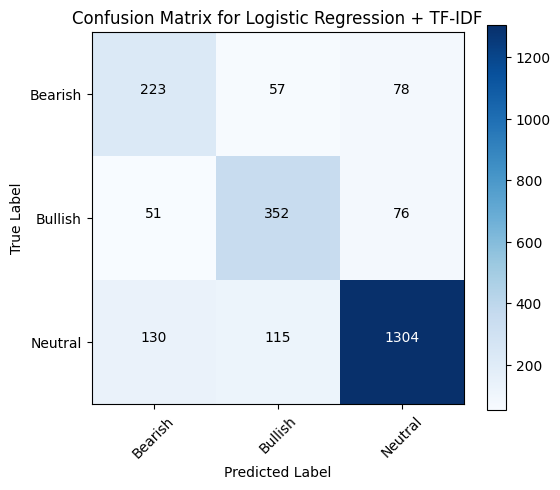

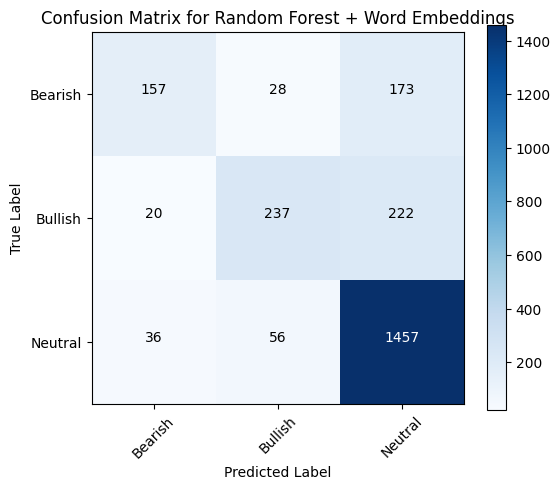

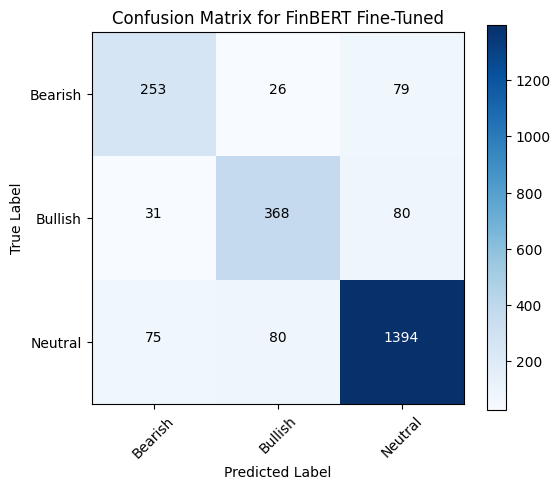

In [39]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=["Bearish", "Bullish", "Neutral"])
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.colorbar()
    tick_marks = range(len(["Bearish", "Bullish", "Neutral"]))
    plt.xticks(tick_marks, ["Bearish", "Bullish", "Neutral"], rotation=45)
    plt.yticks(tick_marks, ["Bearish", "Bullish", "Neutral"])
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

plot_confusion_matrix(test_data['label'], y_pred_baseline, "Logistic Regression + TF-IDF")
plot_confusion_matrix(test_data['label'], y_pred_rf, "Random Forest + Word Embeddings")
plot_confusion_matrix(test_data['label'], predicted_labels, "FinBERT Fine-Tuned")



# Part 4: Analysis and Insights 

## Discussing the results

### Logistic Regression (TF-IDF)

Achieves 79% accuracy, performing well overall.
Strong on Neutral tweets but struggles to correctly classify Bearish and Bullish sentiments.
The confusion matrix shows some misclassification of Bearish and Bullish tweets as Neutral, but not as severe as Random Forest.

### Random Forest (Word Embeddings)

Over-predicts Neutral, leading to high recall for Neutral tweets but poor recall for others.
Accuracy is 78%, but the model struggles with Bearish and Bullish tweets.
Word embeddings improve text representation, but Random Forest lacks the contextual understanding needed for this task.

### FinBERT (Fine-Tuned)

Best model with 84% accuracy and a more balanced classification across all sentiment labels.
High recall for all classes, making fewer misclassifications than the other models.
Shows that fine-tuning a transformer model helps capture financial sentiment better.

## Conclusion

TF-IDF + Logistic Regression provides a decent and lightweight solution, offering solid accuracy with minimal computational cost. It performs well, especially on Neutral tweets, but struggles with the more nuanced Bearish and Bullish sentiments.

FinBERT (Fine-Tuned) is the best-performing model, effectively capturing all sentiment classes. However, it is computationally expensive to train and use, making it less practical for real-time applications without strong hardware.

Random Forest with Word Embeddings could serve as a middle-ground approach, benefiting from contextual understanding while being more efficient than FinBERT. However, in this case, it over-predicts Neutral sentiment, leading to lower overall accuracy. Further tuning would be needed to improve its classification balance.

# Part 5: Discussion of any challenges faced during the test

## This project came with several challenges, mainly in model selection, training time, and optimization.

### Choosing the Right Models
I opted to evaluate these 3 models to understand the trade-offs between computational cost and performance. Each model had distinct advantages: TF-IDF was lightweight, FinBERT provided state-of-the-art results, and Random Forest served as a middle-ground approach.

### Training Time and Computational Cost
Random Forest required extensive tuning, making training slow.
FinBERT Fine-Tuning was the most time-consuming, requiring multiple adjustments to hyperparameters like learning rate and batch size to avoid overfitting. Training on MPS (Mac GPU) helped but was still lengthy.

### Hyperparameter Tuning
Finding the best Logistic Regression and Random Forest settings involved trial and error. RandomizedSearchCV was useful but computationally expensive, so I manually tuned some parameters to save time.

### Handling Class Imbalance
The dataset had many more Neutral tweets than Bullish or Bearish ones, making it difficult for models to correctly classify the less frequent categories. This required careful tuning and evaluation.